# Classification Analysis:  Predicting the Gender of Bikeshare Users Based on Usage Data

<br>

Bike-sharing services offer a means for people to quickly access affordable, short term transportation in urban areas.
Increased automation has allowed for these services to grow more robust in nature and generate more data.
Such data can be used to make improvements in area such as product development and marketing.
By being able to get a comprehensive picture of the people using bike share services, changes can be made that could directly benefit the users of the service.
Such efficient decisionmaking can generate growth and increase revenue for bike-sharing companies.
For this reason, I am interested in predicting the gender of NYC Citi Bike users by creating a model based on the data generated from the service.

The Citi Bike service works by allowing people to pick up bikes at one of hundreds of stations in Manhattan, Brooklyn, Queens and Jersey City.
The users can ride for a predetermined amount of time based on the passes or memberships that they purchase.
They end their time with the bikes by returning them to any of the affiliated stations.

In this study, several types of supervised learning classification models were used to predict the gender of the Citi Bike Users.
Models focused on utilizing factors related to the individual uses of the service.
The different models were compared to better understand their ability to accurately predict gender using multiple forms of statistical evaluation. 
The process used to undertake the study is as follows:


Data Exploration and Analysis
* Viewing the Distribution of the Different Classes
* Checking the Correlatedness of Different Variables
* Interpreting Descriptive Statistics

Preparing The Data For Modeling
* Imputing Outliers
* Class Balancing
* Feature Selection

Modeling the Data 
1. Using All Useful Features
2. Using PCA Components
3. Using Selectkbest Function



In [1]:
%%time

import math
import re
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas
from shapely.geometry import Point
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.mlab import PCA as mlabPCA
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from sklearn.utils import resample
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR, NuSVR, LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error

from datetime import datetime
from dateutil.parser import parse


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="sklearn"  
    )


# Set Plot Style
sns.set_style('darkgrid')
sns.color_palette("Paired")
# Set Float Format
#pd.options.display.float_format = '{:,.0f}'.format


CPU times: user 1.52 s, sys: 429 ms, total: 1.95 s
Wall time: 1.7 s


In [2]:
%%time

## Define Functions

# Converting Values to Datetime
def parse_dates(x):
    return  pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Calculating Distance Between Coordinates
def calculate_distance(x):
    return x['start_station_point'].distance(x['end_station_point'])


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [3]:
%%time

## Import Files

df = pd.read_csv('NYCBikeShare.csv')

CPU times: user 2.17 s, sys: 217 ms, total: 2.39 s
Wall time: 2.41 s


In [4]:
## View Data for Cleaning

#df.head(7)
#df.dtypes
#df.describe()
#df.isnull().sum(axis = 0)
#len(df)


In [5]:
%%time

## Format Column Names

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

## Remove Unnecessary Columns

df = df.drop(['unnamed:_0', 'trip_duration_in_min'], axis=1)


CPU times: user 77.6 ms, sys: 43.1 ms, total: 121 ms
Wall time: 121 ms


In [6]:
%%time

## Convert Categorical ID Numbers to String

df.start_station_id = df.start_station_id.apply(str)
df.end_station_id = df.end_station_id.apply(str)
df.bike_id = df.start_station_id.apply(str)

## Convert Start Time and Stop Time Columns to Datetime 

df.start_time = df.start_time.apply(parse_dates)
df.stop_time = df.stop_time.apply(parse_dates)


CPU times: user 3min 17s, sys: 1.23 s, total: 3min 19s
Wall time: 3min 20s


In [7]:
%%time

## Reorder Columns For Readability

df = df[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude',
         'end_station_id', 'end_station_name', 'end_station_latitude',
         'end_station_longitude', 'trip_duration', 'start_time', 'stop_time',
         'bike_id', 'user_type', 'birth_year', 'gender']]

CPU times: user 161 ms, sys: 41.5 ms, total: 203 ms
Wall time: 202 ms


In [8]:
%%time

## Engineering Features Using Location Based columns

# Latitude and Longitude Columns as Coordinates
df = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.start_station_longitude, df.start_station_latitude))
df = df.rename(index=str, columns={'geometry': 'start_station_point'})

df = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.end_station_longitude, df.end_station_latitude))
df = df.rename(index=str, columns={'geometry': 'end_station_point'})

# Pairs of Starting and Ending Locations Reached during a Single Use/Trip
df['start_end_pair'] = df.start_station_name + " to " + df.end_station_name

# Distance Between Location Pairs in KM
df['distance'] = df.apply(calculate_distance, axis=1).apply(lambda x: x*100)


CPU times: user 47.2 s, sys: 856 ms, total: 48 s
Wall time: 48.1 s


In [9]:
%%time

## Engineering Features Using The Start Datetime Column

# Month
df['month'] = df.start_time.apply(lambda x: x.month)

# Day of week int
df['start_day_of_week_number'] = df.start_time.apply(lambda x: x.weekday())

# Day of Week
df['start_day_of_week'] = df.start_time.apply(lambda x: x.day_name())

# Day of Month
df['start_day_of_month'] = df.start_time.apply(lambda x: x.day)

# Day of Year
df['start_day_of_year'] = df.start_time.apply(lambda x: x.dayofyear)

# Time of day features
df['start_hour'] = df.start_time.apply(lambda x: x.hour)

# Time as a float features
df['start_timestamp'] = df.start_time.apply(lambda x: x.timestamp())


CPU times: user 22.5 s, sys: 471 ms, total: 23 s
Wall time: 23.1 s


In [10]:
%%time

## Approximating the Users' Age Using their Birth Year and Start Time

df['age'] = df.start_time.apply(lambda x: x.year) - df.birth_year

CPU times: user 2.01 s, sys: 73.3 ms, total: 2.08 s
Wall time: 2.08 s


## Data Exploration and Analysis

The Citi Bike Trip Dataset contains information about 735502 anonymised trips that took place between January 2015 and June 2017.
The data was processed to remove trips that are taken by staff and any trips that were below 60 seconds in length.
The dataset originally contained columns related to the location of the stations, duration of the trips, and demographics of the users. 
Additional features were engineered with this information such as the distance between the stations used in a trip and the age of the users.


In [11]:
%%time
## First Several Rows Of Original Dataset
df.iloc[:,0:15].head(7)

CPU times: user 57 ms, sys: 1.42 ms, total: 58.4 ms
Wall time: 57.3 ms


,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,trip_duration,start_time,stop_time,bike_id,user_type,birth_year,gender
0,3212,Christ Hospital,40.735,-74.050,3207,Oakland Ave,40.738,-74.052,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Subscriber,1960.000,1
1,3207,Oakland Ave,40.738,-74.052,3212,Christ Hospital,40.735,-74.050,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,Subscriber,1960.000,1
2,3193,Lincoln Park,40.725,-74.078,3193,Lincoln Park,40.725,-74.078,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,Subscriber,1983.000,1
3,3199,Newport Pkwy,40.729,-74.032,3187,Warren St,40.721,-74.038,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Subscriber,1975.000,1
4,3183,Exchange Place,40.716,-74.033,3192,Liberty Light Rail,40.711,-74.056,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Customer,1984.000,0
5,3198,Heights Elevator,40.749,-74.040,3215,Central Ave,40.747,-74.049,365,2015-10-01 00:41:46,2015-10-01 00:47:51,3198,Customer,1984.000,0
6,3206,Hilltop,40.731,-74.058,3195,Sip Ave,40.731,-74.064,139,2015-10-01 00:43:44,2015-10-01 00:46:03,3206,Subscriber,1988.000,1


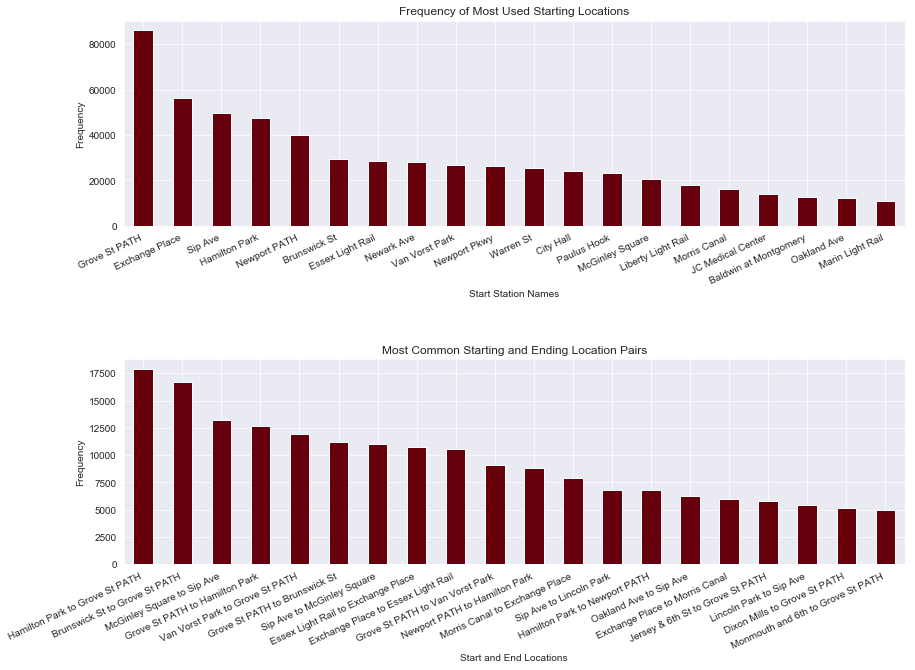

CPU times: user 1.82 s, sys: 180 ms, total: 2 s
Wall time: 1.18 s


In [12]:
%%time

## Barplot of Frequency of use of Specific Starting Stations 

fig = plt.figure(figsize=(14, 10))
fig.subplots_adjust(hspace=.65)

plt.subplot(2, 1, 1)
ax = df.start_station_name.value_counts().head(20).plot(kind='bar', cmap='Reds_r',
                                    
                                    title="Frequency of Most Used Starting Locations")
ax.set_xlabel("Start Station Names")
ax.set_ylabel("Frequency")
plt.xticks(rotation=25, ha='right')

## Barplot of Frequency of use of Specific Ending Stations 

plt.subplot(2, 1, 2)
ax = df.start_end_pair.value_counts().head(20).plot(kind='bar', cmap='Reds_r',
                                    
                                    title="Most Common Starting and Ending Location Pairs")
ax.set_xlabel("Start and End Locations")
ax.set_ylabel("Frequency")
plt.xticks(rotation=25, ha='right')
plt.show()


The bar graphs above references the number of trips that took place over the two year perion during which the data was collected and only represents the classes with the highest frequencies.
While the station names aren't going to be useful to for modeling due to the high number of classes relative to the number of observations, it's useful for gaining an understanding of the nature in which the service is used.

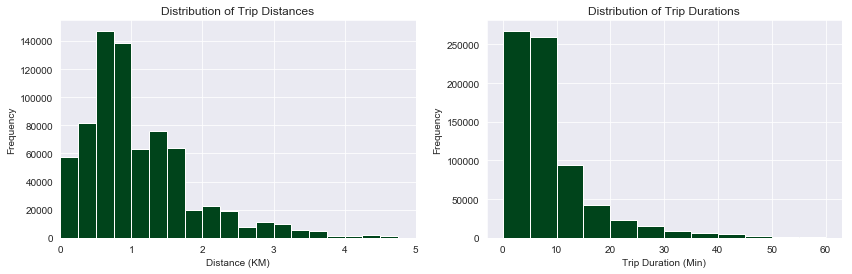

CPU times: user 1.09 s, sys: 103 ms, total: 1.19 s
Wall time: 696 ms


In [13]:
%%time

fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=.5)

## Histogram of Trip Distances

plt.subplot(1, 2, 1)
ax = df.xs('distance', axis=1).plot(kind='hist',  cmap='Greens_r', 
           bins=np.arange(0,5,.25),     title="Distribution of Trip Distances")
ax.set_xlim(0,5)
ax.set_xlabel("Distance (KM)")
ax.set_ylabel("Frequency")

## Histogram of Trip Durations

plt.subplot(1, 2, 2)
ax = df.xs('trip_duration', axis=1).apply(lambda x: x/60).plot(kind='hist',  cmap='Greens_r',
        bins=np.arange(0,65,5),   title="Distribution of Trip Durations")
ax.set_xlabel("Trip Duration (Min)")
ax.set_ylabel("Frequency")


plt.show()


The distribution of the frequency of distances between the start and end stations center around 1 km and the majority of trips lasted less than 10 minutes.
It is important to note that while trip duration and distance are correlated, the users aren't necessarily riding the bikes during the entire time period in which the bikes are checked out.

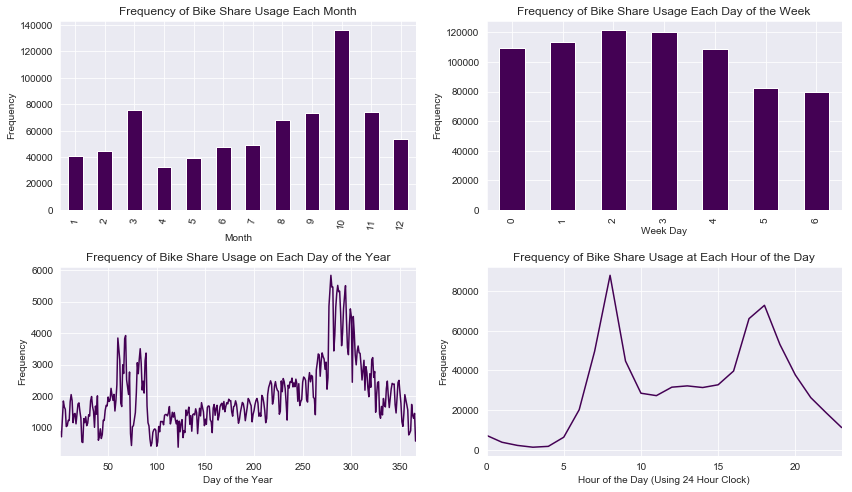

CPU times: user 3.53 s, sys: 224 ms, total: 3.75 s
Wall time: 2.89 s


In [14]:
%%time

## Barplot of Monthly Usage

fig = plt.figure(figsize=(14, 8))
fig.subplots_adjust(hspace=.3)

plt.subplot(2, 2, 1)
ax = df.month.value_counts().sort_index().plot(kind='bar',  cmap='viridis',
                                    
                                    title="Frequency of Bike Share Usage Each Month")
ax.set_xlabel("Month")
ax.set_ylabel("Frequency")
plt.xticks(rotation=80)

## Barplot of Usage During Week

plt.subplot(2, 2, 2)
ax = df.start_day_of_week_number.value_counts().sort_index().plot(kind='bar', cmap='viridis',
                                    title="Frequency of Bike Share Usage Each Day of the Week")
ax.set_xlabel("Week Day")
ax.set_ylabel("Frequency")

## Line Graph of Usage over the Year

plt.subplot(2, 2, 3)
ax = df.start_time.apply(lambda x: x.dayofyear).value_counts().sort_index().plot(kind='line', cmap='viridis',
                                    title="Frequency of Bike Share Usage on Each Day of the Year")
ax.set_xlabel("Day of the Year")
ax.set_ylabel("Frequency")

## Histogram of Trip Distances

plt.subplot(2, 2, 4)
ax = df.start_hour.value_counts().sort_index().plot(kind='line', cmap='viridis',
                                    title="Frequency of Bike Share Usage at Each Hour of the Day")
ax.set_xlabel("Hour of the Day (Using 24 Hour Clock)")
ax.set_ylabel("Frequency")

plt.show()


Most of the trips took place during the Fall with October experiencing a disproportionately higher use of the Citi Bike service.
The frequency of Citi Bike trips was consistent during the weekday and dropped during weekends. 
With regards to the time of day, most trips took place during the morning and evening.
These trends correspond to the average American work week.

In [15]:
df.user_type.value_counts()

Subscriber    688140
Customer       47362
Name: user_type, dtype: int64

The vast majority of the services users are subscribers (annual membership holders) as opposed to customers (single day or 3-day pass holders. While there is a sharp difference between rates of the two user types the model may be able to capture subtle differences between the types of users that could aid in prediction.

In [16]:
df.gender.value_counts()

1    525608
2    150426
0     59468
Name: gender, dtype: int64

The 1 class refers to the number of trips that were taken by a male and the 2 class refers to the number of trips that were taken by a female. 
The the gender is unknown for the observations that contain a 0 gender class.
The sharp imbalance in the gender class will need to be remedied prior to modeling.
The 0 class observations will need to be discarded prior to modeling but even without them, there are enough observations to make a large enough sample of the original dataset.

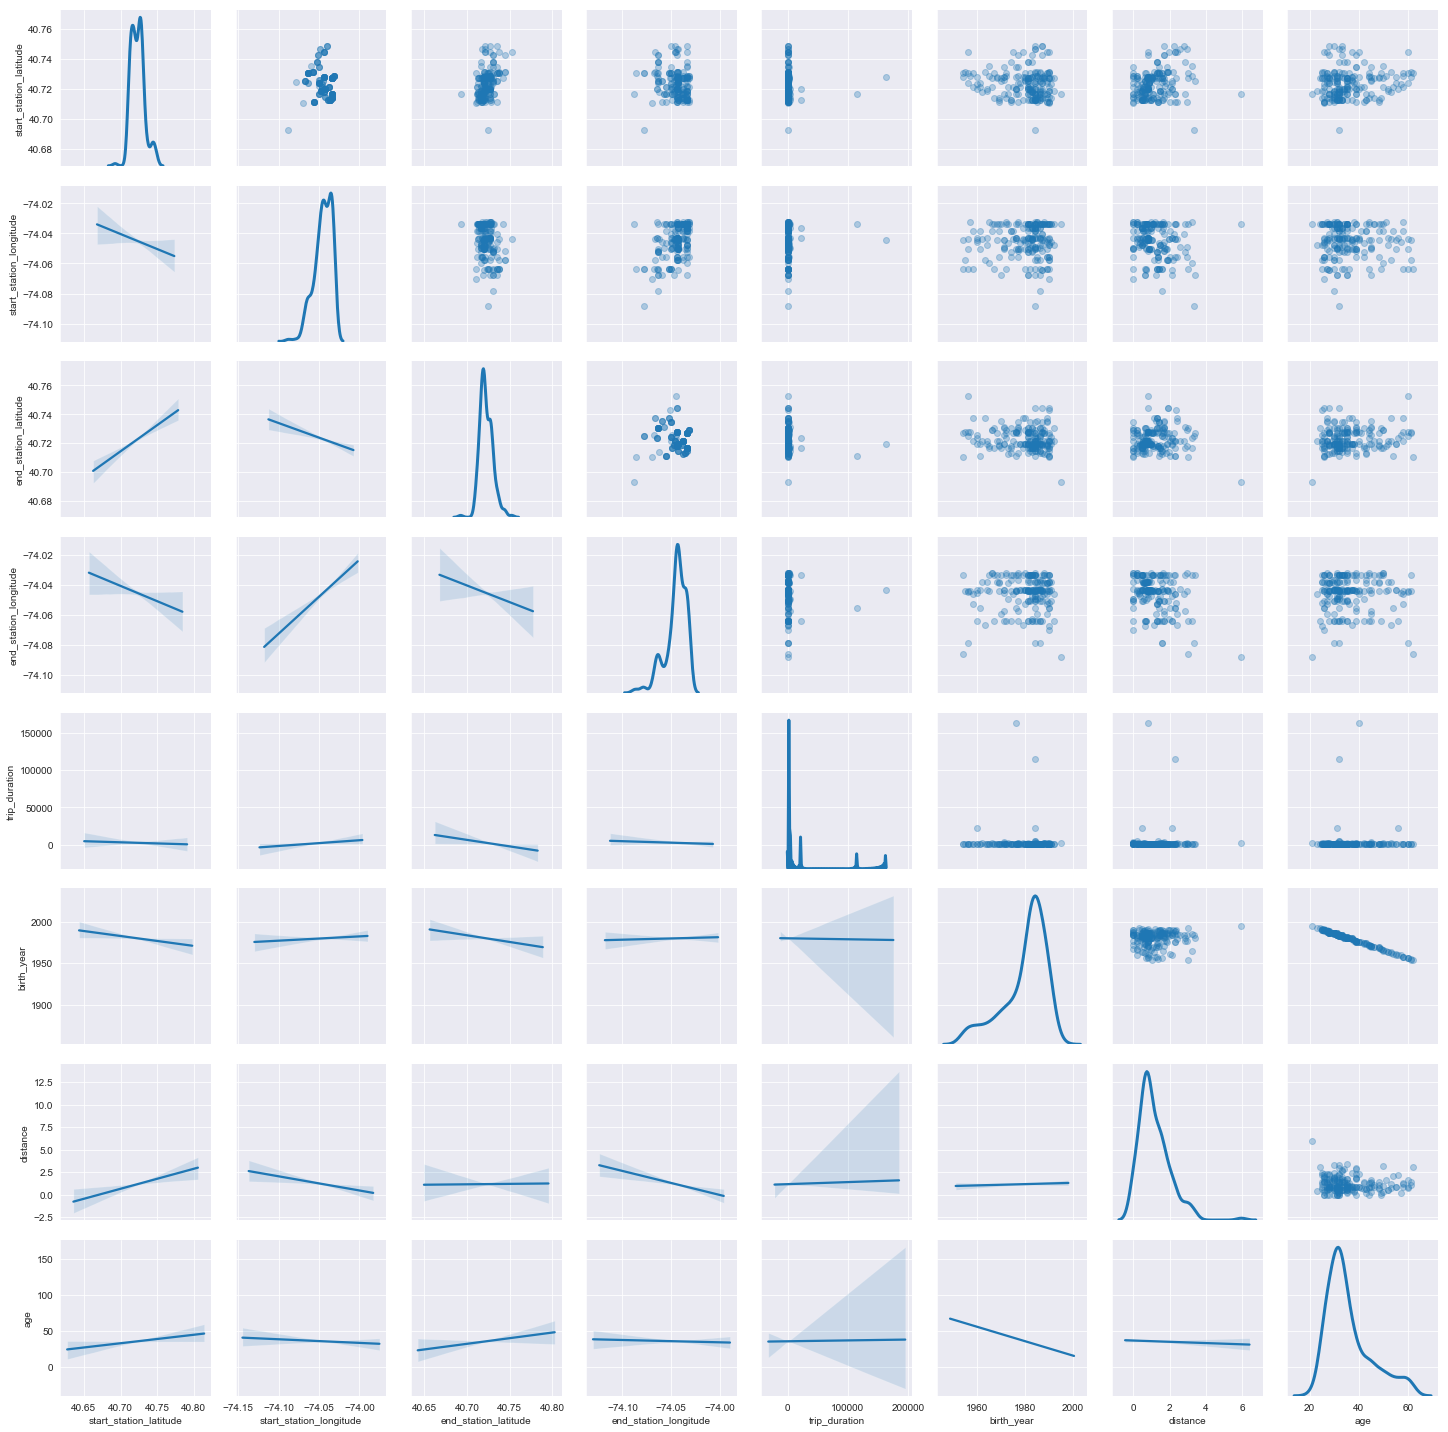

CPU times: user 21.1 s, sys: 2.05 s, total: 23.1 s
Wall time: 10.9 s


In [17]:
%%time

### Creating Scatterplot Matrix with Sample of DataFrame

## Store samples of DataFrame For Visualization

df_sample = df[[ 'start_station_latitude', 'start_station_longitude',
                 'end_station_latitude', 'end_station_longitude', 'trip_duration', 
                 'birth_year', 'distance', 'age']].sample(200)

## Declare Pairgrid
g = sns.PairGrid(df_sample.dropna(), diag_sharey=False)

## Scatterplot
g.map_upper(plt.scatter, alpha=.3)

## Fit line 
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

## KDE plot
g.map_diag(sns.kdeplot, lw=3)
plt.show()

This scatterplot matrix was made to analyze the relationship between the continuous variables. 
The topright half of the matrix gives scatterplots of each combination of variables while the bottom left gives the best fit lines corresponding to the relationship between each pair. 
The diagonals consist of KDE plots which show the shape of the distribution of each variable.

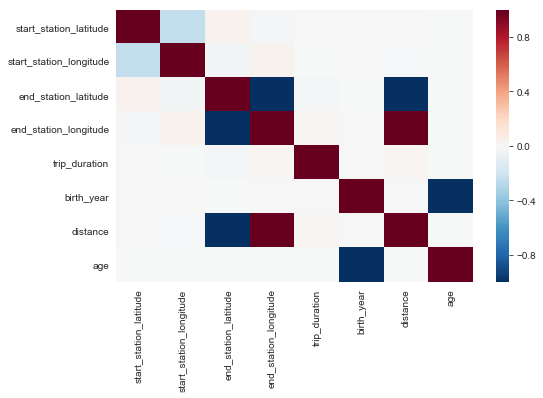

In [18]:
## Visualizing the Correlatedness of the Continuous variables

fig, ax = plt.subplots(figsize=(8,5))         
sns.heatmap(df[[ 'start_station_latitude', 'start_station_longitude',
                 'end_station_latitude', 'end_station_longitude', 'trip_duration', 
                 'birth_year', 'distance', 'age'
               ]].corr(), cmap='RdBu_r', center=0)
plt.show()

Aside from the variables directly related to the locations of the stations, most of the features of this dataset have little to no correlation.

In [19]:
%%time
## Descriptive Statistics of All Continuous Variables
df.describe()

CPU times: user 511 ms, sys: 31.2 ms, total: 542 ms
Wall time: 421 ms


,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,trip_duration,birth_year,gender,distance,month,start_day_of_week_number,start_day_of_month,start_day_of_year,start_hour,start_timestamp,age
count,735502.000,735502.000,735502.000,735502.000,735502.000,735502.000,735502.000,735502.000,735502.000,735502.000,735502.000,735502.000,735502.000,735502.000,735502.000
mean,40.723,-74.046,40.722,-74.045,934.312,1979.544,1.124,1.148,7.264,2.779,15.748,206.134,13.599,1467895633.510,36.408
std,0.008,0.011,0.095,0.173,40638.782,9.371,0.520,19.717,3.372,1.909,8.775,102.695,5.226,13579046.873,9.382
min,40.693,-74.097,0.000,-74.097,61.000,1900.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1442847196.000,16.000
25%,40.718,-74.051,40.717,-74.050,246.000,1975.000,1.000,0.621,4.000,1.000,8.000,114.000,9.000,1458289118.500,30.000
50%,40.722,-74.044,40.721,-74.044,383.000,1982.000,1.000,0.883,8.000,3.000,16.000,231.000,14.000,1470155248.000,34.000
75%,40.728,-74.038,40.727,-74.036,652.000,1986.000,1.000,1.467,10.000,4.000,23.000,292.000,18.000,1477541380.000,41.000
max,40.753,-74.032,40.801,0.000,20260211.000,2000.000,2.000,8449.122,12.000,6.000,31.000,366.000,23.000,1491002734.000,116.000


These descriptive statistics supplement the scatterplot matrix by quantifying the distribution of the variables.
The distributions of the variables related to location and time are relatively consistent because they a limited range and fixed frequencies (e.g. the max start_day_of_month would be 31 because that's the maximum number of days in a month). Potential outliers do exist in the variables that aren't limited to a specific range such as, trip_duration, diatance, and age.

CPU times: user 721 ms, sys: 86 ms, total: 807 ms
Wall time: 810 ms


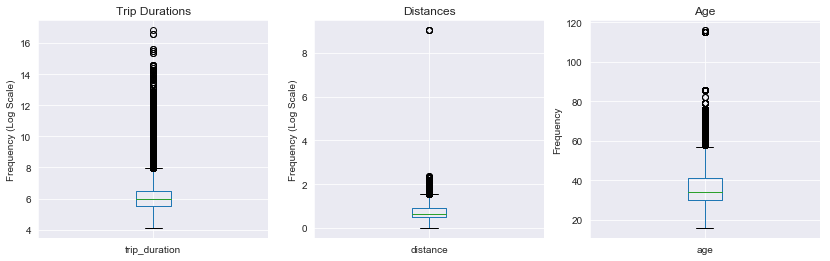

In [20]:
%%time

## Scaled Boxplot of Trip Durations

fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=.5)

plt.subplot(1, 3, 1)
ax = df.trip_duration.apply(math.log).plot(kind='box',
                                    
                                    title="Trip Durations")

ax.set_ylabel("Frequency (Log Scale)")

## Scaled Boxplot of Departure Delay Times

plt.subplot(1, 3, 2)
ax = df.xs('distance', axis=1).apply(lambda x: x+1).apply(math.log).plot(kind='box',
                                    
                                    title="Distances")

ax.set_ylabel("Frequency (Log Scale)")

## Boxplot of Taxi In Times

plt.subplot(1, 3, 3)
ax = df.age.plot(kind='box',
                                    
                                    title="Age")

ax.set_ylabel("Frequency")



These boxplots show that there are outliers in the features that are not fixed to a specific range. Take note of the logarithmic scale being used for trip_duration and distance. This means that any gaps in the points shown for those two plots represent a large amount of distance between the actual points.

## Preparing The Data For Modeling

To prepare the data for modeling, features were selected, the data was resampled to address the class imbalance in the outcome, and three forms of feature selection were implemented. 
This resulted in three sets of variables: One reflecting all of the useful features of the dataset, one reflecting PCA components, and one reflecting features chosen by the selectKbest function.

In [21]:
%%time

## Establish Final Features to be Used For Model

df = df[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 
         'end_station_longitude', 'trip_duration', 'birth_year',  'gender',
         'distance', 'month', 'start_day_of_week', 'start_day_of_week_number',
         'start_day_of_month',  'start_hour',  'age']]

CPU times: user 3.36 s, sys: 180 ms, total: 3.53 s
Wall time: 3.53 s


Features that were useful for modeling were isolated into a final dataframe that would be used for training and testing along side versions of the dataframe that underwent different forms of feature selection.

In [22]:
%%time

## Replace extreme values 

up_quantiles = df.quantile(0.95)
outliers_high = (df > df.quantile(0.95))
df[outliers_high] = np.nan
df.fillna(up_quantiles, inplace=True)


CPU times: user 669 ms, sys: 156 ms, total: 825 ms
Wall time: 838 ms


In [23]:
%%time

## Class Balancing and Resampling

# Separate majority and minority classes
df_majority = df[df.gender==1]
df_minority = df[df.gender==2]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=175000,    # to match majority class
                                 random_state=123) # reproducible results

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=175000,     # to match minority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df = pd.concat([df_majority_downsampled, df_minority_upsampled])

print(df.gender.value_counts())


2    175000
1    175000
Name: gender, dtype: int64
CPU times: user 261 ms, sys: 71.4 ms, total: 332 ms
Wall time: 332 ms


In [24]:
%%time

## Get Dummies so Categorical Variables Can be Used in Classification 

df = pd.get_dummies(df)

## Display New Number of Features

print('Number of Features: '+ str(len(df.columns)))


Number of Features: 20
CPU times: user 188 ms, sys: 36.8 ms, total: 225 ms
Wall time: 237 ms


In [25]:
%%time

## Establish Feature and Outcome Variables to be Used for Modeling Based on Original Features

x = df.drop(['gender'], axis=1)
y = df.gender


CPU times: user 33.6 ms, sys: 19.8 ms, total: 53.4 ms
Wall time: 52.3 ms


In [26]:
%%time

## PCA

# Normalize the Data for PCA

X = StandardScaler().fit_transform(x)

# Perform PCA

sklearn_pca = PCA(n_components=15)
Y_sklearn = sklearn_pca.fit_transform(X)

# Turn PCA Result into a Dataframe

pca_components = pd.DataFrame(data=Y_sklearn)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.11734949 0.11443877 0.10420818 0.06938038 0.06330845 0.06283703
 0.06224703 0.06114731 0.05891544 0.05544417 0.05506357 0.04994729
 0.04780308 0.02962832 0.02681896]
CPU times: user 3.33 s, sys: 1.73 s, total: 5.06 s
Wall time: 2.17 s


In [27]:
%%time

## Establish variables based on select K best to be used for modeling

selector = SelectKBest(f_classif, k=15)
k_predictors = selector.fit_transform(x,y)


CPU times: user 143 ms, sys: 70.7 ms, total: 214 ms
Wall time: 215 ms


In [28]:
%%time

## Train Test Split the Three Sets of Feature and Outcome Variables

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

kx_train, kx_test, ky_train, ky_test = train_test_split(k_predictors, y, test_size=0.2, random_state=21)

px_train, px_test, py_train, py_test = train_test_split(pca_components, y, test_size=0.2, random_state=22)


CPU times: user 449 ms, sys: 61 ms, total: 510 ms
Wall time: 517 ms


Training and testing sets of three variables were generated to be used in modeling.
The x and y variables represent the variables to be used for modeling that reflect the all of the useful features of the data. 
The px and py variables represent the variables to be used for modeling that reflect PCA components of the initial features.
The kx and ky variables represent the variables to be used for modeling that reflect features chosen by selectKbest.


## Modeling the Data using all Useful Features

### Naive Bayes

In [29]:
%%time

## train and fit model

bnb = BernoulliNB().fit(x_train, y_train)


CPU times: user 155 ms, sys: 52.6 ms, total: 208 ms
Wall time: 163 ms


In [30]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(bnb.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(bnb, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(bnb, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, bnb.predict(x_test)))+'\n')

print(classification_report(y_test, bnb.predict(x_test)))


accuracy score:
0.5178285714285714

cross validation:
[0.51574888 0.51978571 0.51714286 0.51835714 0.51746553]

cross validation with AUC:
[0.51926461 0.52026021 0.51739659 0.51680239 0.51938241]

confusion matrix:
[[28369  6767]
 [26985  7879]]

              precision    recall  f1-score   support

           1       0.51      0.81      0.63     35136
           2       0.54      0.23      0.32     34864

   micro avg       0.52      0.52      0.52     70000
   macro avg       0.53      0.52      0.47     70000
weighted avg       0.53      0.52      0.47     70000

CPU times: user 2.77 s, sys: 485 ms, total: 3.25 s
Wall time: 842 ms


### K Nearest Neighbors 

In [31]:
%%time

## train and fit model

knn = neighbors.KNeighborsClassifier(n_neighbors=10).fit(x_train, y_train)


CPU times: user 874 ms, sys: 38.4 ms, total: 912 ms
Wall time: 915 ms


In [32]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(knn.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(knn, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(knn, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, knn.predict(x_test)))+'\n')

print(classification_report(y_test, knn.predict(x_test)))


accuracy score:
0.6428428571428572

cross validation:
[0.57374473 0.56014286 0.57564286 0.56385714 0.57411244]

cross validation with AUC:
[0.60221602 0.58692612 0.60661112 0.59415656 0.60318188]

confusion matrix:
[[23217 11919]
 [13082 21782]]

              precision    recall  f1-score   support

           1       0.64      0.66      0.65     35136
           2       0.65      0.62      0.64     34864

   micro avg       0.64      0.64      0.64     70000
   macro avg       0.64      0.64      0.64     70000
weighted avg       0.64      0.64      0.64     70000

CPU times: user 27.3 s, sys: 253 ms, total: 27.5 s
Wall time: 27.7 s


### Decision Tree

In [33]:
%%time

## train and fit model

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=8,
    max_depth=25,
    ).fit(x_train, y_train)


CPU times: user 1.13 s, sys: 40.2 ms, total: 1.17 s
Wall time: 1.18 s


In [34]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(decision_tree.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(decision_tree, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(decision_tree, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, decision_tree.predict(x_test)))+'\n')

print(classification_report(y_test, decision_tree.predict(x_test)))


accuracy score:
0.9059857142857143

cross validation:
[0.76973073 0.774      0.79278571 0.77778571 0.76934067]

cross validation with AUC:
[0.7859251  0.79259912 0.79709476 0.78732531 0.78129589]

confusion matrix:
[[30600  4536]
 [ 2045 32819]]

              precision    recall  f1-score   support

           1       0.94      0.87      0.90     35136
           2       0.88      0.94      0.91     34864

   micro avg       0.91      0.91      0.91     70000
   macro avg       0.91      0.91      0.91     70000
weighted avg       0.91      0.91      0.91     70000

CPU times: user 2.6 s, sys: 130 ms, total: 2.73 s
Wall time: 2.75 s


### Random Forest

In [35]:
%%time

## train and fit model

rf = ensemble.RandomForestClassifier()

parameters = { 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy'],
              'max_depth': list(np.arange(85, 111, 5)), 
              'min_samples_split': list(np.arange(3, 12, 2))
             }

acc_scorer = make_scorer(accuracy_score)

rfc = GridSearchCV(rf, parameters, scoring=acc_scorer).fit(x_train,  y_train)

print(rfc.best_params_)


{'criterion': 'entropy', 'max_depth': 85, 'max_features': 'sqrt', 'min_samples_split': 3}
CPU times: user 17min 56s, sys: 22 s, total: 18min 18s
Wall time: 18min 22s


In [36]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(rfc.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(rfc, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(rfc, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, rfc.predict(x_test)))+'\n')

print(classification_report(y_test, rfc.predict(x_test)))


accuracy score:
0.9426571428571429

cross validation:
[0.811942   0.82264286 0.82185714 0.81464286 0.8173441 ]

cross validation with AUC:
[0.90020833 0.90318671 0.89839968 0.89670665 0.90036234]

confusion matrix:
[[32719  2417]
 [ 1597 33267]]

              precision    recall  f1-score   support

           1       0.95      0.93      0.94     35136
           2       0.93      0.95      0.94     34864

   micro avg       0.94      0.94      0.94     70000
   macro avg       0.94      0.94      0.94     70000
weighted avg       0.94      0.94      0.94     70000

CPU times: user 31min 36s, sys: 41.4 s, total: 32min 18s
Wall time: 32min 25s


### Logistic Regression 

In [37]:
%%time

## train and fit model

lr = LogisticRegression(penalty='l1' ).fit(x_train, y_train)


CPU times: user 8min 21s, sys: 1.88 s, total: 8min 23s
Wall time: 8min 26s


In [38]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(lr.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(lr, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(lr, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, lr.predict(x_test)))+'\n')

print(classification_report(y_test, lr.predict(x_test)))


accuracy score:
0.5649

cross validation:
[0.56731662 0.55857143 0.56678571 0.56071429 0.56525466]

cross validation with AUC:
[0.58824061 0.57685143 0.58724502 0.58079623 0.5846629 ]

confusion matrix:
[[19120 16016]
 [14441 20423]]

              precision    recall  f1-score   support

           1       0.57      0.54      0.56     35136
           2       0.56      0.59      0.57     34864

   micro avg       0.56      0.56      0.56     70000
   macro avg       0.57      0.56      0.56     70000
weighted avg       0.57      0.56      0.56     70000

CPU times: user 9min 47s, sys: 3.05 s, total: 9min 51s
Wall time: 9min 51s


### Support Vector

In [39]:
%%time

## train and fit model

svc = SVC(max_iter=100000).fit(x_train, y_train)


CPU times: user 36min 53s, sys: 4.66 s, total: 36min 57s
Wall time: 37min 4s


In [40]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(svc.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(svc, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(svc, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, svc.predict(x_test)))+'\n')

print(classification_report(y_test, svc.predict(x_test)))


accuracy score:
0.8121571428571429

cross validation:
[0.64852511 0.6395     0.649      0.64442857 0.64261733]

cross validation with AUC:
[0.70929007 0.7017278  0.71106317 0.7048801  0.706588  ]

confusion matrix:
[[27628  7508]
 [ 5641 29223]]

              precision    recall  f1-score   support

           1       0.83      0.79      0.81     35136
           2       0.80      0.84      0.82     34864

   micro avg       0.81      0.81      0.81     70000
   macro avg       0.81      0.81      0.81     70000
weighted avg       0.81      0.81      0.81     70000

CPU times: user 1h 26min 59s, sys: 23 s, total: 1h 27min 22s
Wall time: 1h 27min 46s


### Gradient Boost 

In [41]:
%%time

## train and fit model

cl = ensemble.GradientBoostingClassifier()

parameters = { 
              'n_estimators': list(np.arange(200, 301, 50)),
              'max_depth': list(range(1,7))
             }

acc_scorer = make_scorer(accuracy_score)

clf = GridSearchCV(cl, parameters, scoring=acc_scorer).fit(x_train,  y_train)

print(clf.best_params_)


{'max_depth': 6, 'n_estimators': 300}
CPU times: user 1h 9min 11s, sys: 57.4 s, total: 1h 10min 8s
Wall time: 1h 10min 42s


In [42]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(clf.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(clf, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(clf, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, clf.predict(x_test)))+'\n')

print(classification_report(y_test, clf.predict(x_test)))


accuracy score:
0.8123285714285714

cross validation:
[0.79380044 0.79021429 0.79392857 0.79428571 0.79562826]

cross validation with AUC:
[0.8757069  0.87151076 0.87727955 0.87346044 0.87618924]

confusion matrix:
[[27230  7906]
 [ 5231 29633]]

              precision    recall  f1-score   support

           1       0.84      0.77      0.81     35136
           2       0.79      0.85      0.82     34864

   micro avg       0.81      0.81      0.81     70000
   macro avg       0.81      0.81      0.81     70000
weighted avg       0.81      0.81      0.81     70000

CPU times: user 2h 1min 39s, sys: 1min 38s, total: 2h 3min 17s
Wall time: 2h 4min 25s


The random forest model had the best performance out of all of the models run with all of the dataset's useful features. 
Cross validation showed few signs of overfitting with this model. 
The strength of this model when it comes to making predictions using this data comes from its ability to separate datapoints using binary splits, which is especially useful for isolated latitude and longitude features. 
The decision tree had similar accuracy scores but lower cross validation scores.
Naive bayes performed poorly with this data. This is likely due to the naturally high correlatedness of variables related to station locations.
The support vector classifier didn't have the best performance but there is room for this model to improve as computational resources increase in availability.
KNN and logistic regression had poor performance (although better than Naive Bayes). This likely has to do with these models being unable to capture nuances between different groups of observations and the interactions between the variables.

In general, the models that relied on the dataset’s most useful features had the best performance in the study.
An advantage of using all of the useful features is that as much meaningful variance was captured by the models as possible.
This method of feature selection also risks including features with variance that doesn’t aid in the predictive power of the models.
However, this potential disadvantage didn’t hamper the model’s ability to perform well because many of the features that would noticeably have a negative effect on the models were already left out.


## Modeling the Data using PCA Components

### Naive Bayes

In [43]:
%%time

## train and fit model

p_bnb = BernoulliNB().fit(px_train, py_train)


CPU times: user 147 ms, sys: 159 ms, total: 305 ms
Wall time: 488 ms


In [44]:
%%time
## Model Evaluation

print("accuracy score:\n" + str(p_bnb.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_bnb, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_bnb, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_bnb.predict(px_test)))+'\n')

print(classification_report(py_test, p_bnb.predict(px_test)))


accuracy score:
0.5502142857142858

cross validation:
[0.55914286 0.54507143 0.54642857 0.54678571 0.5525    ]

cross validation with AUC:
[0.57789219 0.56450698 0.5667154  0.56039858 0.57511073]

confusion matrix:
[[19050 15935]
 [15550 19465]]

              precision    recall  f1-score   support

           1       0.55      0.54      0.55     34985
           2       0.55      0.56      0.55     35015

   micro avg       0.55      0.55      0.55     70000
   macro avg       0.55      0.55      0.55     70000
weighted avg       0.55      0.55      0.55     70000

CPU times: user 2.7 s, sys: 526 ms, total: 3.23 s
Wall time: 930 ms


### K Nearest Neighbors 

In [45]:
%%time

## train and fit model

p_knn = neighbors.KNeighborsClassifier(n_neighbors=10).fit(px_train, py_train)


CPU times: user 543 ms, sys: 32.6 ms, total: 575 ms
Wall time: 592 ms


In [46]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_knn.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_knn, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_knn, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_knn.predict(px_test)))+'\n')

print(classification_report(py_test, p_knn.predict(px_test)))


accuracy score:
0.7042571428571428

cross validation:
[0.61992857 0.60428571 0.61314286 0.61135714 0.61735714]

cross validation with AUC:
[0.66272518 0.65338118 0.6568706  0.65719946 0.6609031 ]

confusion matrix:
[[24259 10726]
 [ 9976 25039]]

              precision    recall  f1-score   support

           1       0.71      0.69      0.70     34985
           2       0.70      0.72      0.71     35015

   micro avg       0.70      0.70      0.70     70000
   macro avg       0.70      0.70      0.70     70000
weighted avg       0.70      0.70      0.70     70000

CPU times: user 2min 14s, sys: 743 ms, total: 2min 15s
Wall time: 2min 15s


### Decision Tree

In [47]:
%%time

## train and fit model

p_decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=8,
    max_depth=25,
    ).fit(px_train, py_train)


CPU times: user 6.02 s, sys: 57.7 ms, total: 6.08 s
Wall time: 6.15 s


In [48]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_decision_tree.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_decision_tree, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_decision_tree, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_decision_tree.predict(px_test)))+'\n')

print(classification_report(py_test, p_decision_tree.predict(px_test)))


accuracy score:
0.8523714285714286

cross validation:
[0.68385714 0.67585714 0.67942857 0.68564286 0.68307143]

cross validation with AUC:
[0.69080319 0.6969681  0.69616824 0.68798376 0.68954705]

confusion matrix:
[[28124  6861]
 [ 3473 31542]]

              precision    recall  f1-score   support

           1       0.89      0.80      0.84     34985
           2       0.82      0.90      0.86     35015

   micro avg       0.85      0.85      0.85     70000
   macro avg       0.86      0.85      0.85     70000
weighted avg       0.86      0.85      0.85     70000

CPU times: user 12.5 s, sys: 151 ms, total: 12.7 s
Wall time: 12.8 s


### Random Forest

In [49]:
%%time

## train and fit model

parameters = { 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy'],
              'max_depth': list(np.arange(85, 111, 5)), 
              'min_samples_split': list(np.arange(3, 12, 2))
             }

acc_scorer = make_scorer(accuracy_score)

p_rfc = GridSearchCV(rf, parameters, scoring=acc_scorer).fit(px_train, py_train)

print(p_rfc.best_params_)


{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 3}
CPU times: user 59min 7s, sys: 28.5 s, total: 59min 35s
Wall time: 1h 4s


In [50]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_rfc.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_rfc, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_rfc, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_rfc.predict(px_test)))+'\n')

print(classification_report(py_test, p_rfc.predict(px_test)))


accuracy score:
0.9099

cross validation:
[0.7205     0.71721429 0.72242857 0.718      0.71907143]

cross validation with AUC:
[0.79895943 0.79188841 0.79536728 0.79454343 0.79382654]

confusion matrix:
[[31428  3557]
 [ 2750 32265]]

              precision    recall  f1-score   support

           1       0.92      0.90      0.91     34985
           2       0.90      0.92      0.91     35015

   micro avg       0.91      0.91      0.91     70000
   macro avg       0.91      0.91      0.91     70000
weighted avg       0.91      0.91      0.91     70000

CPU times: user 1h 45min 11s, sys: 46.7 s, total: 1h 45min 57s
Wall time: 1h 46min 30s


### Logistic Regression 

In [51]:
%%time

## train and fit model

p_lr = LogisticRegression(penalty='l1' ).fit(px_train, py_train)


CPU times: user 355 ms, sys: 328 ms, total: 683 ms
Wall time: 946 ms


In [52]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_lr.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_lr, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_lr, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_lr.predict(px_test)))+'\n')

print(classification_report(py_test, p_lr.predict(px_test)))


accuracy score:
0.5630571428571428

cross validation:
[0.56735714 0.56242857 0.56128571 0.55357143 0.57035714]

cross validation with AUC:
[0.59083488 0.57737498 0.5780386  0.57477415 0.59073444]

confusion matrix:
[[19236 15749]
 [14837 20178]]

              precision    recall  f1-score   support

           1       0.56      0.55      0.56     34985
           2       0.56      0.58      0.57     35015

   micro avg       0.56      0.56      0.56     70000
   macro avg       0.56      0.56      0.56     70000
weighted avg       0.56      0.56      0.56     70000

CPU times: user 3.84 s, sys: 1.04 s, total: 4.89 s
Wall time: 1.54 s


### Support Vector 

In [53]:
%%time

## train and fit model

p_svc = SVC(max_iter=100000).fit(px_train, py_train)


CPU times: user 35min 46s, sys: 4.57 s, total: 35min 51s
Wall time: 35min 56s


In [54]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_svc.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_svc, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_svc, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_svc.predict(px_test)))+'\n')

print(classification_report(py_test, p_svc.predict(px_test)))


accuracy score:
0.6128285714285714

cross validation:
[0.62828571 0.62464286 0.61914286 0.61128571 0.6185    ]

cross validation with AUC:
[0.673734   0.66724184 0.66410188 0.65644863 0.66499073]

confusion matrix:
[[11823 23162]
 [ 3940 31075]]

              precision    recall  f1-score   support

           1       0.75      0.34      0.47     34985
           2       0.57      0.89      0.70     35015

   micro avg       0.61      0.61      0.61     70000
   macro avg       0.66      0.61      0.58     70000
weighted avg       0.66      0.61      0.58     70000

CPU times: user 51min 28s, sys: 28.9 s, total: 51min 57s
Wall time: 52min 41s


### Gradient Boost

In [58]:
%%time

## train and fit model

parameters = { 
              'n_estimators': list(np.arange(200, 301, 50)),
              'max_depth': list(range(1,7))
             }

p_clf = GridSearchCV(cl, parameters, scoring=acc_scorer).fit(px_train,  py_train)

print(p_clf.best_params_)


{'max_depth': 6, 'n_estimators': 300}
CPU times: user 2h 23min 21s, sys: 1min 10s, total: 2h 24min 31s
Wall time: 2h 25min 20s


In [59]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_clf.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_clf, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_clf, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_clf.predict(px_test)))+'\n')

print(classification_report(py_test, p_clf.predict(px_test)))


accuracy score:
0.7171428571428572

cross validation:
[0.6865     0.68307143 0.68242857 0.67728571 0.67821429]

cross validation with AUC:
[0.75167391 0.75097952 0.74425176 0.7422314  0.74329686]

confusion matrix:
[[23635 11350]
 [ 8450 26565]]

              precision    recall  f1-score   support

           1       0.74      0.68      0.70     34985
           2       0.70      0.76      0.73     35015

   micro avg       0.72      0.72      0.72     70000
   macro avg       0.72      0.72      0.72     70000
weighted avg       0.72      0.72      0.72     70000

CPU times: user 3h 10min 26s, sys: 1min 8s, total: 3h 11min 35s
Wall time: 3h 11min 56s


The random forest model had the best performance out of all of the models run with 15 of the dataset's best PCA components. 
While cross validation did show few signs of overfitting with this model, those scores were significantly lower than the accuracy score. 
This is a noticeably lower performance than the random forest model that used all of the available features. 
In general, the models that used the PCA components had lower scores than the models that used all of the dataset's useful features and the models that used features chosen by selectKbest.
However, KNN and naive bayes did perform better with PCA components. 
The increase in performance of these two model types can be attributed to the increased significance of the remaining components allowing the algorithms to better classify the observations.

Using a limited number of PCA components from the dataset likely removed some variance that was important to the predictive accuracy of the models.
Using PCA components does have the advantage of reducing computational complexity and runtimes but this did not make up for the drop in accuracy of the better performing model types.
 

## Modeling the Data using Features Chosen with the SelectKbest Function

### Naive Bayes

In [60]:
%%time

## train and fit model

k_bnb = BernoulliNB().fit(kx_train, ky_train)


CPU times: user 110 ms, sys: 167 ms, total: 277 ms
Wall time: 451 ms


In [61]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_bnb.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_bnb, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_bnb, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_bnb.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_bnb.predict(kx_test)))


accuracy score:
0.5106571428571428

cross validation:
[0.50732091 0.5124634  0.50307143 0.50946496 0.51025073]

cross validation with AUC:
[0.51368549 0.51966594 0.50947354 0.51439286 0.51752307]

confusion matrix:
[[27680  7163]
 [27091  8066]]

              precision    recall  f1-score   support

           1       0.51      0.79      0.62     34843
           2       0.53      0.23      0.32     35157

   micro avg       0.51      0.51      0.51     70000
   macro avg       0.52      0.51      0.47     70000
weighted avg       0.52      0.51      0.47     70000

CPU times: user 2.07 s, sys: 434 ms, total: 2.5 s
Wall time: 776 ms


### K Nearest Neighbors

In [62]:
%%time

## train and fit model

k_knn = neighbors.KNeighborsClassifier(n_neighbors=10).fit(kx_train, ky_train)


CPU times: user 701 ms, sys: 23.4 ms, total: 724 ms
Wall time: 741 ms


In [63]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_knn.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_knn, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_knn, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_knn.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_knn.predict(kx_test)))


accuracy score:
0.6578142857142857

cross validation:
[0.57960146 0.58202986 0.57757143 0.57968426 0.57675548]

cross validation with AUC:
[0.61396027 0.61704577 0.61071388 0.61467668 0.61054569]

confusion matrix:
[[23178 11665]
 [12288 22869]]

              precision    recall  f1-score   support

           1       0.65      0.67      0.66     34843
           2       0.66      0.65      0.66     35157

   micro avg       0.66      0.66      0.66     70000
   macro avg       0.66      0.66      0.66     70000
weighted avg       0.66      0.66      0.66     70000

CPU times: user 16.9 s, sys: 139 ms, total: 17.1 s
Wall time: 17.2 s


### Decision Tree

In [64]:
%%time

## train and fit model

k_decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=8,
    max_depth=25,
    ).fit(kx_train, ky_train)


CPU times: user 1.18 s, sys: 24.3 ms, total: 1.2 s
Wall time: 1.21 s


In [65]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_decision_tree.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_decision_tree, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_decision_tree, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_decision_tree.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_decision_tree.predict(kx_test)))


accuracy score:
0.9051857142857143

cross validation:
[0.80079994 0.8015856  0.79871429 0.79591399 0.78869919]

cross validation with AUC:
[0.80169748 0.80471628 0.80455413 0.80902564 0.81185549]

confusion matrix:
[[30260  4583]
 [ 2054 33103]]

              precision    recall  f1-score   support

           1       0.94      0.87      0.90     34843
           2       0.88      0.94      0.91     35157

   micro avg       0.91      0.91      0.91     70000
   macro avg       0.91      0.91      0.91     70000
weighted avg       0.91      0.91      0.91     70000

CPU times: user 2.37 s, sys: 58 ms, total: 2.43 s
Wall time: 2.45 s


### Random Forest

In [66]:
%%time

## train and fit model

parameters = { 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy'],
              'max_depth': list(np.arange(85, 111, 5)), 
              'min_samples_split': list(np.arange(3, 12, 2))
             }

acc_scorer = make_scorer(accuracy_score)

k_rfc = GridSearchCV(rf, parameters, scoring=acc_scorer).fit(kx_train, ky_train)

print(k_rfc.best_params_)


{'criterion': 'entropy', 'max_depth': 110, 'max_features': 'log2', 'min_samples_split': 3}
CPU times: user 16min 2s, sys: 19.9 s, total: 16min 22s
Wall time: 16min 29s


In [67]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_rfc.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_rfc, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_rfc, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_rfc.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_rfc.predict(kx_test)))


accuracy score:
0.9357

cross validation:
[0.82772659 0.82151275 0.8145     0.81962997 0.81605829]

cross validation with AUC:
[0.89991833 0.9033447  0.90034001 0.89884141 0.90075802]

confusion matrix:
[[32054  2789]
 [ 1712 33445]]

              precision    recall  f1-score   support

           1       0.95      0.92      0.93     34843
           2       0.92      0.95      0.94     35157

   micro avg       0.94      0.94      0.94     70000
   macro avg       0.94      0.94      0.94     70000
weighted avg       0.94      0.94      0.94     70000

CPU times: user 25min 54s, sys: 33.1 s, total: 26min 27s
Wall time: 26min 36s


### Logistic Regression 

In [68]:
%%time

## train and fit model

k_lr = LogisticRegression(penalty='l1' ).fit(kx_train, ky_train)


CPU times: user 3min 5s, sys: 1.26 s, total: 3min 6s
Wall time: 3min 8s


In [69]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_lr.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_lr, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_lr, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_lr.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_lr.predict(kx_test)))


accuracy score:
0.5666

cross validation:
[0.5614599  0.56167417 0.56242857 0.5655404  0.56875491]

cross validation with AUC:
[0.58012646 0.57967288 0.58045103 0.58831403 0.58435808]

confusion matrix:
[[19252 15591]
 [14747 20410]]

              precision    recall  f1-score   support

           1       0.57      0.55      0.56     34843
           2       0.57      0.58      0.57     35157

   micro avg       0.57      0.57      0.57     70000
   macro avg       0.57      0.57      0.57     70000
weighted avg       0.57      0.57      0.57     70000

CPU times: user 6min 41s, sys: 1.92 s, total: 6min 43s
Wall time: 6min 41s


### Support Vector

In [70]:
%%time

## train and fit model

k_svc = SVC(max_iter=100000).fit(kx_train, ky_train)


CPU times: user 35min 41s, sys: 5.42 s, total: 35min 46s
Wall time: 35min 56s


In [71]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_svc.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_svc, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_svc, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_svc.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_svc.predict(kx_test)))


accuracy score:
0.6996285714285714

cross validation:
[0.61367045 0.6232412  0.614      0.61747268 0.61654404]

cross validation with AUC:
[0.65999793 0.666629   0.65626719 0.66057826 0.66058045]

confusion matrix:
[[22186 12657]
 [ 8369 26788]]

              precision    recall  f1-score   support

           1       0.73      0.64      0.68     34843
           2       0.68      0.76      0.72     35157

   micro avg       0.70      0.70      0.70     70000
   macro avg       0.70      0.70      0.70     70000
weighted avg       0.70      0.70      0.70     70000

CPU times: user 1h, sys: 19.2 s, total: 1h 20s
Wall time: 1h 29s


### Gradient Boost

In [72]:
%%time

## train and fit model

parameters = { 
              'n_estimators': list(np.arange(200, 301, 50)),
              'max_depth': list(range(1,7))
             }

k_clf = GridSearchCV(cl, parameters, scoring=acc_scorer).fit(kx_train,  ky_train)

print(k_clf.best_params_)


{'max_depth': 6, 'n_estimators': 300}
CPU times: user 59min 26s, sys: 43.5 s, total: 1h 10s
Wall time: 1h 17s


In [73]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_clf.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_clf, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_clf, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_clf.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_clf.predict(kx_test)))


accuracy score:
0.8093714285714285

cross validation:
[0.7912292  0.79065781 0.78971429 0.79091364 0.79262804]

cross validation with AUC:
[0.87434743 0.87213197 0.8726776  0.86991358 0.87318839]

confusion matrix:
[[26914  7929]
 [ 5415 29742]]

              precision    recall  f1-score   support

           1       0.83      0.77      0.80     34843
           2       0.79      0.85      0.82     35157

   micro avg       0.81      0.81      0.81     70000
   macro avg       0.81      0.81      0.81     70000
weighted avg       0.81      0.81      0.81     70000

CPU times: user 1h 34min 31s, sys: 1min 16s, total: 1h 35min 48s
Wall time: 1h 36min 13s


The random forest model had the best performance out of all of the models run with features chosen using the selectkbest function. Cross validation showed few signs of overfitting with this model. The random forest model using selectkbest still had lower accuracy than the model that used all of the available features in the dataset, implying that useful features were removed prior to modeling. Since selectKbest removes a low number of features in this case, this would mean that the majority of the dataset's useful features had meaningful variance .
Logistic regression’s performance didn’t differ much regardless of feature selection, implying that the model type doesn’t suit the bikeshare data.

When it comes to comparing full featured models and models that used sectkbest, most of the full featured models slightly outperformed their counterparts that used K best features.
Using selectKbest allows for computational complexity to be reduced without abstracting the individual features (unlike PCA).
However, in a situation where most of the features had a positive effect on the ability of the model to predict gender, this form of feature selection wasn’t particularly helpful.


## Analysis and Conclusion

The random forest model using all of the dataset's useful features the best model when it came to predicting the gender of the Citi Bike users.
It is also important to note that the support vector classifier could also prove valuable when it comes to making predictions if larger amounts of computational resources are available due to its ability to draw distinct boundaries among the classes; a quality that is especially useful for location based data.

This study established the best suprvised modeling technique and feature classification pairing for the gender of the citibike users. The next step in using this data to discern the demographics of the users based on their usage of the service would be to collect more types of data and go more in depth into which features have a greater impact on the likelihood of a user being a particular gender. This includes collecting data from different sources and engineering more features. Afterwards the study can be expanded to include different types of demographical classes as outcomes such as age. 

Understanding how to better utilize supervised modeling techniques to predict gender, will give insight as to what kind of people are using the bike share service and particular habits different types of customers share.
This can allow for more direct marketing to specific types of users or changes in the product that better match how the service is used. Through the use of cheap and accessible data, decisions can be made that can result in increased efficiency and revenue for the company.